<b>AML2019</b>

# Useful articles

- [Dealing with categorical features](https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d)

- ['statsmodels' library](https://www.statsmodels.org/stable/index.html)

- [some potentially useful packages](https://medium.com/activewizards-machine-learning-company/top-15-python-libraries-for-data-science-in-in-2017-ab61b4f9b4a7)

- [other pot. useful packages](https://www.kdnuggets.com/2018/06/top-20-python-libraries-data-science-2018.html/2)

- ['seaborn' library (visualization)](https://seaborn.pydata.org/tutorial.html)

- [Nyttig eksempel](https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5)

# Declaring libraries and importing data

In [1]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For performance evaluation
from time import time

os.environ["OPENBLAS_NUM_THREADS"] = "1"   # Required by implicit
base = "/mnt/workspace/AML-2019/Challenges/House_Pricing/challenge_data/"

pricesRawDF = pd.read_csv(base + 'train.csv', keep_default_na = False)
#pricesRawDF[20:25]

# Data exploration
## Data visualization

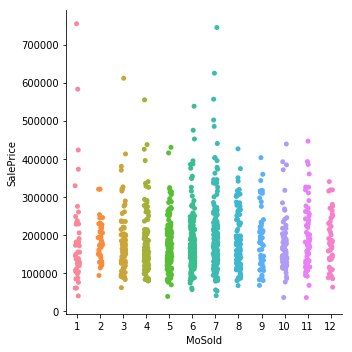

In [13]:
sns.catplot(x="MoSold", y="SalePrice", data=pricesRawDF);

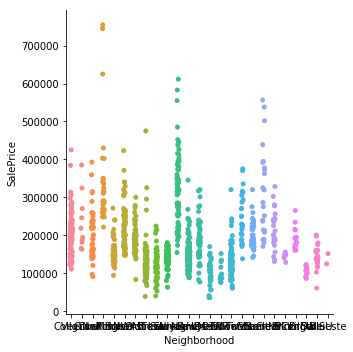

In [14]:
sns.catplot(x="Neighborhood", y="SalePrice", data=pricesRawDF);

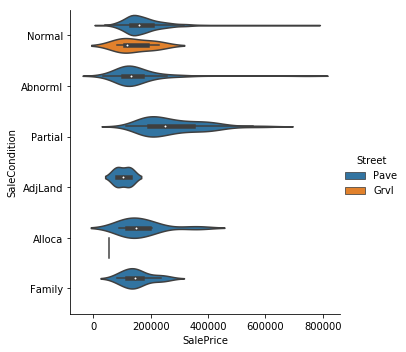

In [12]:
sns.catplot(x="SalePrice", y="SaleCondition", hue="Street",
            kind="violin", data=pricesRawDF);

## Descriptive statistics

In [2]:
# To check if number of unique elements in coloumn exceeds number of types in data description
# Only useful for columns with categorical data 
nr_column_categories = []

for column in pricesRawDF:
    nr_column_categories.append((column, pricesRawDF[column].nunique()))

for elements in nr_column_categories[:10]:
    print(elements)

('Id', 1200)
('MSSubClass', 15)
('MSZoning', 5)
('LotFrontage', 107)
('LotArea', 913)
('Street', 2)
('Alley', 3)
('LotShape', 4)
('LandContour', 4)
('Utilities', 2)


What is worth noting here is that in some of the columns containing categorical data, not all the different categories are represented. For example the an element of the column "MSSubClass" can take 16 unique values based upon the its description in "Data Description.rtf". This means that transforming the values in categorical columns to numerical values, or one-hot-encoding will be a bit cumbersome. 

In [3]:
# To check if there are any elements missing in a certain column
pricesRawDF.isnull().values.any()
# True if keep_default_na = True
# False if keep_default_na = False

False

In [9]:
# Trying to plot histograms of individual data columns to find the distribution of 
# of data with respect to specific coloumns. Such that we possibly can eliminate outliers 
pricesRawDF.columns[1:-1]




Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Reformatting data
In a statistical model or machine learning model, it is much easier to use numerical data rather than numerical data. For the parameters if the data set that are categorical, we can either make them numerical directly or split them into individual boolean columns by one-hot encoding. we have chosen to one-hot encode som columns and make some numerical.  

In [20]:
# Transforming the categories we want to be numeric, to numeric values
from sklearn.preprocessing import LabelEncoder
from variables import cats_split, cats_num

# The categories we want to split
categorical_to_split = ['MSSubClass', 'MSZoning', 'Alley', 'LotConfig', 'Utilities',
                       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                       'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 
                       'MiscFeature', 'SaleType', 'SaleCondition']

# Casting the type of all columns we want to one-hot-key to strings
for cat in categorical_to_split:
    pricesRawDF[cat] = pricesRawDF[cat].astype(str, errors = 'ignore')

# Categories to make numerical
categorical_to_make_numerical = ['Street', 'LotShape', 'LandContour', 'LandSlope', 'CentralAir',
                                'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                                'PoolQC', 'Fence']

# Function to make desired columns numerical
def numerize(rawDF, complete_mapping_dictionary):
    DF = rawDF.copy()
    errors = []
    for mapping_dictionary in complete_mapping_dictionary:
        # Fetching column name
        col_name = mapping_dictionary['name']
        # Fetching column
        column_to_numerize = DF[col_name].copy()
        # Creating columns of same size, and correct type
        numerized_column = pd.Series(np.zeros([column_to_numerize.size]), dtype=np.int8, name=col_name)
        # Resetting error_counter
        error_counter = 0
        # Looping through elements of column
        for index, value in column_to_numerize.iteritems():
            if (value in mapping_dictionary):
                numerized_column.at[index] = mapping_dictionary[value]
            else:
                error_counter += 1
        # Merging numerized column into dataframe
        DF.drop(labels=col_name, axis=1, inplace=True)
        DF[col_name] = numerized_column
        # Appending errors to error vector
        errors.append((col_name, error_counter))
    return errors, DF

# Function for one-hot-encoding a single column, given the column and its possible categories
def split_and_filter(col_name, DF, categories):
    # Extracting column to split
    column_to_split = DF[col_name].copy()
    # Setting new names for columns
    new_col_names = [(col_name + '_' + category) for category in categories]
    # Creating expanded DF of zeros
    splitDF = pd.DataFrame(np.zeros([column_to_split.size,len(categories)], dtype = np.int8), columns = categories)
    # Resetting error_counter
    error_counter = 0
    # Looping through series and setting correct values in new DF
    for index, value in column_to_split.iteritems():
        # Checking if the value is valid, i.e exists in the set of possible categories for one column
        if (value in categories):
            splitDF.at[index, value] = 1
        else:
            error_counter += 1
    # Renaming columns of new dataframe
    splitDF.columns = new_col_names
    '''# Following two lines used for debugging
    newColDF = pd.merge(column_to_split.to_frame(), splitDF, left_index=True, right_index=True)
    print(newColDF[:5])'''
    # Merging expansion of one column with full DataFrame
    newDF = pd.merge(DF, splitDF, left_index=True, right_index=True)
    # Dropping original column
    newDF.drop([col_name], axis=1, inplace=True)
    # Deleting unused dataframe and series to conserve memory
    del splitDF
    del column_to_split
    return error_counter, newDF

# Function to one-hot encode the entire dataframe given a dataframe and list of names for new columns
def category_splitting(rawDF, list_of_categories):
    first_err, newDF = split_and_filter(list_of_categories[0][0], rawDF, list_of_categories[0][1:])
    errors = [(list_of_categories[0][0], first_err)]
    for column_to_split in list_of_categories[1:]:
        nth_err, newDF = split_and_filter(column_to_split[0], newDF, column_to_split[1:])
        errors.append((column_to_split[0], nth_err))
    return errors, newDF

# Function to reformat a dataset to our desired format
def reformat_dataset(rawDF):
    num_errors, numerizedDF = numerize(rawDF, cats_num)
    split_errors, reformattedDF = category_splitting(numerizedDF, cats_split)
    errors = num_errors + split_errors
    return errors, reformattedDF

errors, rfmtDF = reformat_dataset(pricesRawDF)
rfmtDF.to_csv('clean_train_data.csv')

# Pre-processing 
## Error Detection
We have found some errors earlier when reformatting the categorical columns. Now it remains to find the remaining errors in the columns we have not yet looked at. 

In [9]:
# Find errors in remaining columns
processed_cols = categorical_to_split + categorical_to_make_numerical
remaining_cols = [column for column in pricesRawDF.columns if column not in processed_cols]
 
remainingColsDF = pd.read_csv(base + 'train.csv', keep_default_na = True)[remaining_cols]# Keep default NaN values now, because we want to find errors in numerical columns
remainingColsDF.isnull().sum()

Id                 0
LotFrontage      210
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         6
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       67
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [14]:
errors.append(('LotFrontage', 210))
errors.append(('MasVnrArea', 6))
errors.append(('GarageYrBlt', 67))

Now let as look at what errors we have got 

In [15]:
for columns in errors:
    if(columns[1] > 0):
        print(columns)

('BldgType', 106)
('Exterior2nd', 85)
('MasVnrType', 6)
('LotFrontage', 210)
('MasVnrArea', 6)
('GarageYrBlt', 67)


Here we can see that we have some errors. After inspecting the dataset, we can see that for the case of "LotFrontage", "MasVnrArea" and "GarageYrBlt", the errors are due to some cells having the value "NA". Meaning (probably) that the feature is "Not applicable". For these three categories it is expedient to set the value of these cells to zero. Now we expect the indeces that give errors in the other categories. Let us find the indeces that give errors in the other categories.

In [24]:
from variables import error_detect

error_indeces = []
for defect_col_name in error_detect:
    err = [defect_col_name[0]]
    defect_col = pricesRawDF[defect_col_name[0]]
    categories = defect_col_name[1:]
    for index, value in defect_col.iteritems():
        if value not in categories:
            err.append((index, value))
    error_indeces.append(err)
    
col2print = error_indeces[4]
for el in col2print:
    print(el)

MasVnrType
(234, 'NA')
(529, 'NA')
(650, 'NA')
(936, 'NA')
(973, 'NA')
(977, 'NA')


Now we can see that the errors are due to the following reasons:
    
* MSZoning:  
 * The one category is called 'C' in the data description, but is called 'C (all)' in the data. 
 * Here we need to change the dictionary
* Neighborhood:  
 * 179 elements that should have been spelled as 'Names', have been misspelled as 'NAmes'. 
 * Here we need to change the dictionary
* BldgType:  
 * Spelling error: "2fmCon" instead of "2FmCon"
 * Spelling error: "Duplex" instead of "Duplx"
 * Spelling error: Many elements have been spelled as "Twnhs". the problem now is that it is impossible to discern whether they have ment the category "TwnhsI" or "TwnhsE"
 * Correcting function (that fixes spelling errors and combines the two "Twnhs" categories to one)
* Exterior2nd:  
 * Spelling error: "Wd Shng" instead of "Wd Sdng"
 * Spelling error: "CmentBd" instead of "CemntBd"
 * Spelling error: "Brk Cmn" instead of "BrkComm"
 * Correcting function
* MasVnrType:  
 * Six elements where this category is not applicable
 * No correction is required

In [ ]:
# Implement correcting function
def correct_known_spelling_errors(rawDF, reformedDF):
    return 0

## Feature selection

In [23]:
corrDF = rfmtDF.copy()
corrDF.drop('Id', axis=1, inplace=True)
corr_matrix = corrDF.corr(method="pearson")
corr_matrix[:5]

LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
LotArea       1.000000     0.096609    -0.004041   0.004622      0.008509   
OverallQual   0.096609     1.000000    -0.081059   0.568827      0.554535   
OverallCond  -0.004041    -0.081059     1.000000  -0.383713      0.086674   
YearBuilt     0.004622     0.568827    -0.383713   1.000000      0.583559   
YearRemodAdd  0.008509     0.554535     0.086674   0.583559      1.000000   

              BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
LotArea         0.192061    0.120707  -0.009916     0.236482  0.274067   
OverallQual     0.220272   -0.053848   0.315937     0.541657  0.467076   
OverallCond    -0.039001    0.043802  -0.138360    -0.169360 -0.164252   
YearBuilt       0.238620   -0.042948   0.155875     0.397170  0.289182   
YearRemodAdd    0.124249   -0.063336   0.181789     0.296812  0.238847   

                      ...            SaleType_ConLw  SaleType_ConLI  \
LotArea               ...                 -0.015860        0.000857   
OverallQual           ...                 -0.023622        0.004444   
OverallCond           ...                 -0.021279        0.001829   
YearBuilt             ...                 -0.026168        0.003121   
YearRemodAdd          ...                 -0.044726        0.012019   

              SaleType_ConLD  SaleType_Oth  SaleCondition_Normal  \
LotArea            -0.006593     -0.005188              0.008064   
OverallQual        -0.041524     -0.047422             -0.134936   
OverallCond        -0.070004     -0.057231              0.173964   
YearBuilt          -0.048287      0.017207             -0.143759   
YearRemodAdd       -0.019718     -0.000971             -0.105590   

              SaleCondition_Abnorml  SaleCondition_AdjLand  \
LotArea                   -0.023552              -0.013931   
OverallQual               -0.107876              -0.046211   
OverallCond               -0.056015              -0.042267   
YearBuilt                 -0.137219              -0.050736   
YearRemodAdd              -0.165581              -0.045060   

              SaleCondition_Alloca  SaleCondition_Family  \
LotArea                   0.001772             -0.011283   
OverallQual              -0.051565             -0.019301   
OverallCond              -0.048822             -0.029358   
YearBuilt                -0.010439             -0.017834   
YearRemodAdd             -0.016561             -0.030857   

              SaleCondition_Partial  
LotArea                    0.017358  
OverallQual                0.319314  
OverallCond               -0.151069  
YearBuilt                  0.344607  
YearRemodAdd               0.324262  

[5 rows x 248 columns]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error